# Overcoming Gibb's: Subtraction methods

This notebook implements two subtraction methods: 
Subtraction of polynomials and trigonometric functions to achieve accurate Fourier transforms of smooth, non-periodic data on a uniform grid.

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
<head>
<title>JabRef References output</title>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<style type="text/css">
body { font-size: 12px; font-family: Arial, sans-serif; }
dt { margin-top: 1em; font-weight: bold; }
@media print {
	dt { page-break-after: avoid; }
	dd { page-break-before: avoid; }
}
</style>
</head>
<body>
<dl>
<dd>Green, M.</dd>
<dd><i>Spectral Solution with a Subtraction Method to Improve Accuracy</i></dd>
<dd><b>2011</b></dd>

</dl>
</body>
</html>

My experience with subtraction methods is positive. They can yield high accuracy for periodic extensions.
However, for my intended area of application: building a parallelised PDE solver for wave equations with high accuracy, I faced many stability issues. 

For an introduction, I recommend the seminal paper
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
<head>
<title>JabRef References output</title>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<style type="text/css">
body { font-size: 12px; font-family: Arial, sans-serif; }
dt { margin-top: 1em; font-weight: bold; }
@media print {
	dt { page-break-after: avoid; }
	dd { page-break-before: avoid; }
}
</style>
</head>
<body>
<dl>
<dd>Sk&ouml;llermo, G.</dd>
<dd><i>A Fourier method for the numerical solution of Poisson’s equation</i></dd>
<dd>Mathematics of Computation, <b>1975</b>, Vol. 29(131), pp. 697-711</dd>

</dl>
</body>
</html>

The literature suggests different function families as subtraction functions. 

## Trigonometric subtraction

The basic idea of all subtraction methods is similar. One estimates suitable derivatives of the input function and subtracts a linear combination of suitable basis functions. The resulting function can then be expanded using another suitable basis. 

Trigonometric subtraction can be implemented as follows: 
- Given a grid: $0, \Delta x, ..., L - \Delta x, L$
- Estimate even derivatives $f^{(0)}(x_0), f^{(0)}(x_1), f^{(2)}(x_0), f^{(2)}(x_1), $... of $f(x)$ at $x_0=0$ and $x_1 = L$ 
- Set them to $0$ by subtracting suitable linear combinations of cosine functions evaluated on the discrete grid
- Define antisymmetric extension as {$f(x_0), ..., f(x_1), -f(x_1 - \Delta x), ..., -f(x_0 + \Delta x)$}
- Accurate Fourier transform of antisymmetric extension

It is useful to construct an antisymmetric extension because the 0-th order derivatives, i.e. the function values, are known already.
Alternatively, a sine transform could be used which is twice as fast as computing the DFT of the antisymmetric extension. 
The stability and complexity of the algorithm is determined by how many derivatives are estimated. All odd derivatives of the antisymmetric extension exist at the domain boundary for smooth input data. Therefore, ensuring continuity of the 0-th, 2nd, 4th etc. derivative at the domain boundary ensures 3rd, 5th, 7th order etc. convergence. There are additional discretisation errors from the DFT and the approximation of the boundary derivatives discussed in the above references.

In [41]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def forward_difference_matrix(order, dx):
    """
    Create a forward difference matrix of a given order and spacing.

    Args:
        order (int): The order of the matrix.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The forward difference matrix.
    """
    size = order
    mat = np.zeros((size, size))
    for k in range(1, size + 1):
        for j in range(1, size + 1):
            mat[j - 1, k - 1] = (j * dx) ** k / np.math.factorial(k)

    return mat

def backward_difference_matrix(order, dx):
    """
    Create a backward difference matrix of a given order and spacing.

    Args:
        order (int): The order of the matrix.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The backward difference matrix.
    """
    size = order
    mat = np.zeros((size, size))
    for k in range(1, size + 1):
        for j in range(1, size + 1):
            mat[j - 1, k - 1] = (-j * dx) ** k / np.math.factorial(k)

    return mat

def forward_difference_vector(order, f):
    """
    Create a forward difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The forward difference vector.
    """
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j - 1] = f[j] - f[0]
    return diff

def backward_difference_vector(order, f):
    """
    Create a backward difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The backward difference vector.
    """
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j - 1] = f[-1 - j] - f[-1]
    return diff

def iterative_refinement(A, b, tolerance=1e-12):
    """
    Solve a system of linear equations Ax = b using iterative refinement.

    Args:
        A (numpy.ndarray): The matrix A.
        b (numpy.ndarray): The vector b.
        tolerance (float): The tolerance for the residual error.

    Returns:
        numpy.ndarray: The solution vector x.
    """
    x = np.linalg.solve(A, b)
    residual = b - A @ x
    residual_error = np.sum(np.abs(residual))

    iteration = 0
    while residual_error > tolerance:
        correction = np.linalg.solve(A, residual)
        x += correction
        residual = b - A @ x
        residual_error = np.sum(np.abs(residual))
        iteration += 1
        if iteration > 1000:
            break

    return x

def shift_x(x):
    """
    Normalize the x values to a range of [0, 1].

    Args:
        x (numpy.ndarray): The input x values.

    Returns:
        numpy.ndarray: The normalized x values.
    """
    return (x - x[0]) / (x[-1] - x[0])

def cosine_difference_vector(order, f, Dl, Dr):
    """
    Create a cosine difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.
        Dl (numpy.ndarray): The left difference values.
        Dr (numpy.ndarray): The right difference values.

    Returns:
        numpy.ndarray: The cosine difference vector.
    """
    b = np.zeros(2 * order)
    b[0] = f[0]
    b[1] = f[-1]
    #Even derivatives at left boundary
    for i in range(1, order):
        b[i * 2] = Dl[2*i-1] / (np.pi) ** (2 * i)

    #Even derivatives at right boundary
    for i in range(1, order):
        b[i * 2 + 1] = Dr[2*i-1] / (np.pi) ** (2 * i)

    return b

def cosine_difference_matrix(order):
    """
    Create a cosine difference matrix of a given order.

    Args:
        order (int): The order of the matrix.

    Returns:
        numpy.ndarray: The cosine difference matrix.
    """
    A = np.zeros((order * 2, order * 2))
    for i in range(order):
        derivative = 2 * i
        for j in range(1, 2 * order + 1):
            A[2 * i, j - 1] = j ** derivative * (-1) ** i
            A[2 * i + 1, j - 1] = j ** derivative * (-1) ** i * (-1) ** j

    return A

def reconstruct(C, x, derivative_order=0):
    """
    Reconstruct a function from its cosine series coefficients.

    Args:
        C (numpy.ndarray): The cosine series coefficients.
        x (numpy.ndarray): The x values.
        derivative_order (int): The order of the derivative to reconstruct.

    Returns:
        numpy.ndarray: The reconstructed function values.
    """
    f = np.zeros(x.shape)
    L = x[-1] - x[0]
    x_eval = shift_x(x)
    for k in range(1, len(C) + 1):
        f += C[k - 1] * np.real((1j * k * np.pi / L) ** derivative_order * np.exp(1j * k * np.pi * x_eval))

    return f

def get_shift_function(f, n_accuracy, x):
    """
    Calculate the shift function for a given function, order, and x values.

    Args:
        f (numpy.ndarray): The function values.
        n_accuracy (int): The number of even derivatives made continuous
        x (numpy.ndarray): The x values.

    Returns:
        tuple: The shift function values and the coefficients.
    """
    x_eval = shift_x(x)
    dx = x_eval[1] - x_eval[0]
    A = forward_difference_matrix(n_accuracy * 2, dx)
    b = forward_difference_vector(n_accuracy * 2, f)
    Dl = iterative_refinement(A, b)

    A = backward_difference_matrix(n_accuracy * 2, dx)
    b = backward_difference_vector(n_accuracy * 2, f)

    Dr = iterative_refinement(A, b)

    A = cosine_difference_matrix(n_accuracy + 1)
    b = cosine_difference_vector(n_accuracy + 1, f, Dl, Dr)
    C = iterative_refinement(A, b)

    shift = reconstruct(C, x_eval)
    return shift, C

def antisymmetric_extension(f):
    """
    Extend a function with its antisymmetric part.

    Args:
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The extended function values.
    """
    f_ext = np.concatenate([f, -np.flip(f)[1:-1]])
    return f_ext

def get_k(p, dx):
    """
    Calculate the k values for a given array and spacing.

    Args:
        p (numpy.ndarray): The input array.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The k values.
    """
    N = len(p)
    L = N * dx
    k = 2 * np.pi / L * np.arange(-N / 2, N / 2)
    return np.fft.ifftshift(k)


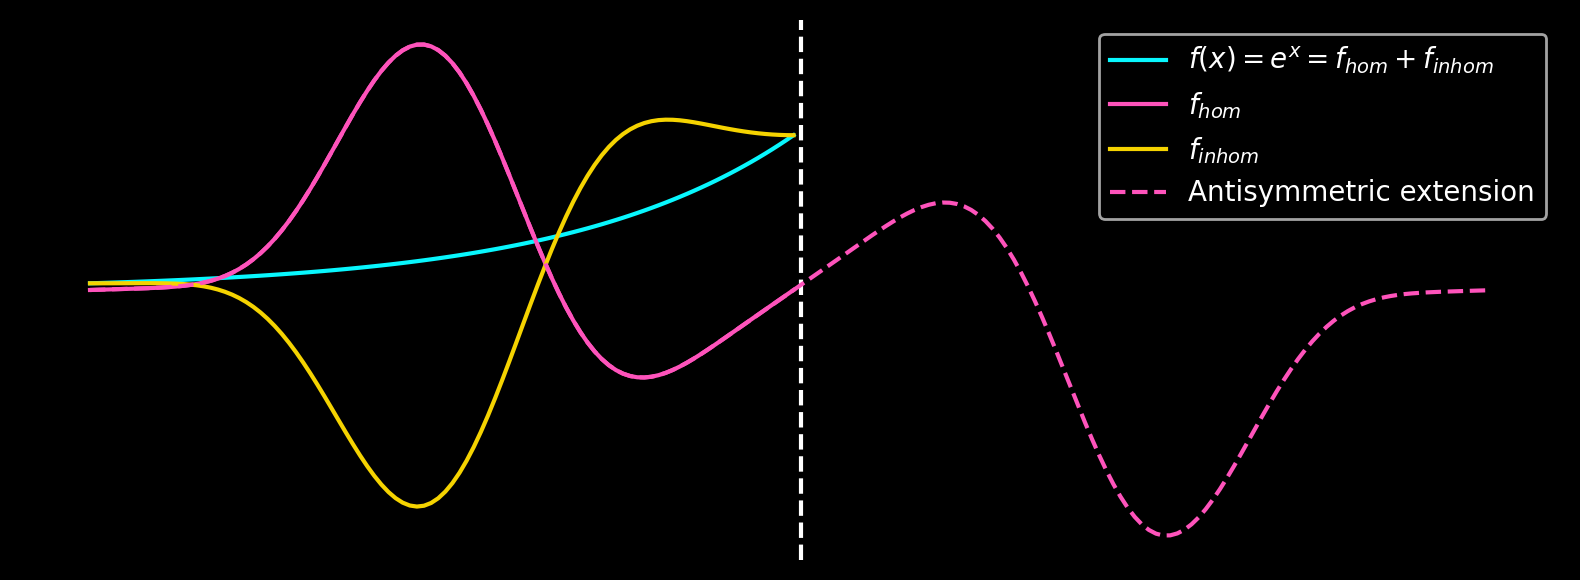

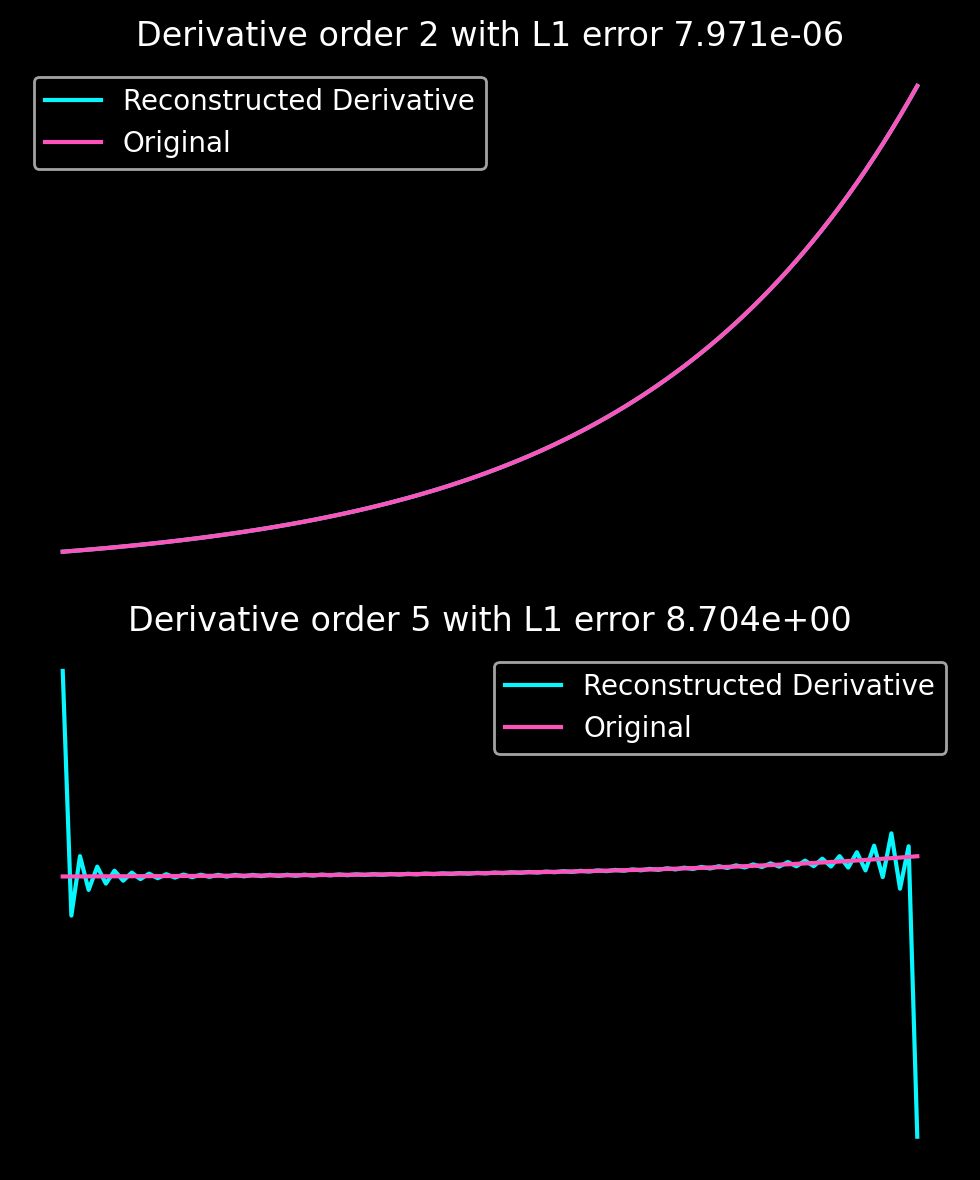

In [42]:


# Configurable parameters
N        = 100  # Size of input domain
# Accuracy of subtraction
# For a given n_accuracy, n_accuracy even derivatives are made continuous (and the function values at the boundaries are subtracted)
# Therefore, the antisymmetric extension will be in C1 + 2 * n_accuracy derivatives
# The Fourier coefficients then decay as O(3 + 2 * n_accuracy)
n_accuracy = 2

# Define the domain and the function
L = np.pi

x = np.linspace(0, L, N)
def func(x):
    return np.exp(x)
f = func(x)
dx = x[1] - x[0]

# Get the shift function and coefficients
shift, C = get_shift_function(f, n_accuracy, x)
hom      = f - shift
f_ext    = antisymmetric_extension(hom)
f_hat    = scipy.fft.fft(f_ext)

# Get the k values
k = get_k(f_hat, dx)


colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]

plt.style.use('dark_background')
plt.figure(figsize=(8, 3), dpi=200)
plt.axis("off")
plt.plot(f, c = colors[0], label=r"$f(x) = e^x = f_{hom} + f_{inhom}$")
plt.plot(hom, c = colors[1], label=r"$f_{hom}$")
plt.plot(shift, c = colors[2], label=r"$f_{inhom}$")
plt.axvline(len(x), ls="dashed", c="w")
plt.plot(f_ext, c = colors[1], ls="dashed", label="Antisymmetric extension")
plt.legend()
plt.tight_layout()
plt.savefig("figures/subtraction_trigonometric_extension.png", bbox_inches='tight')
plt.show()

# Number of subplots
num_subplots = 2

# Create subplots
fig, axs = plt.subplots(num_subplots, 1,  figsize=(5 , 3* num_subplots), dpi=200)


# Loop through different subtraction orders
for i, o in enumerate([2, 5]):
    forg = func(x)
    frec = scipy.fft.ifft(f_hat * (1j * k) ** o).real[:N]  # Use only the first N elements (the original domain)
    reco = reconstruct(C, x, derivative_order = o)
    sumo = frec + reco

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].get_xaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

    # Plot the sum and the original function in subplots
    axs[i].set_title(f"Derivative order {o} with L1 error {np.mean(np.abs(sumo - forg)):3.3e}")
    axs[i].plot(x, sumo, label="Reconstructed Derivative", c = colors[0])
    axs[i].plot(x, forg, label="Original", c = colors[1])
    axs[i].legend()

# Adjust layout
fig.tight_layout()
fig.savefig("figures/subtraction_trigonometric_accuracy.png", bbox_inches='tight')


### Decay of Fourier coefficients as function of subtraction order

2
4
8


/tmp/ipykernel_6637/581003427.py:29: RuntimeWarning: divide by zero encountered in power
  plt.loglog(k[0:n], np.abs(f_hat[n_start]) * (k[0:n]**n_poly)/(k[n_start]**n_poly), c=colors[i], ls="dotted", label=r"$\propto k^{"+f"{n_poly}"+r"}$")


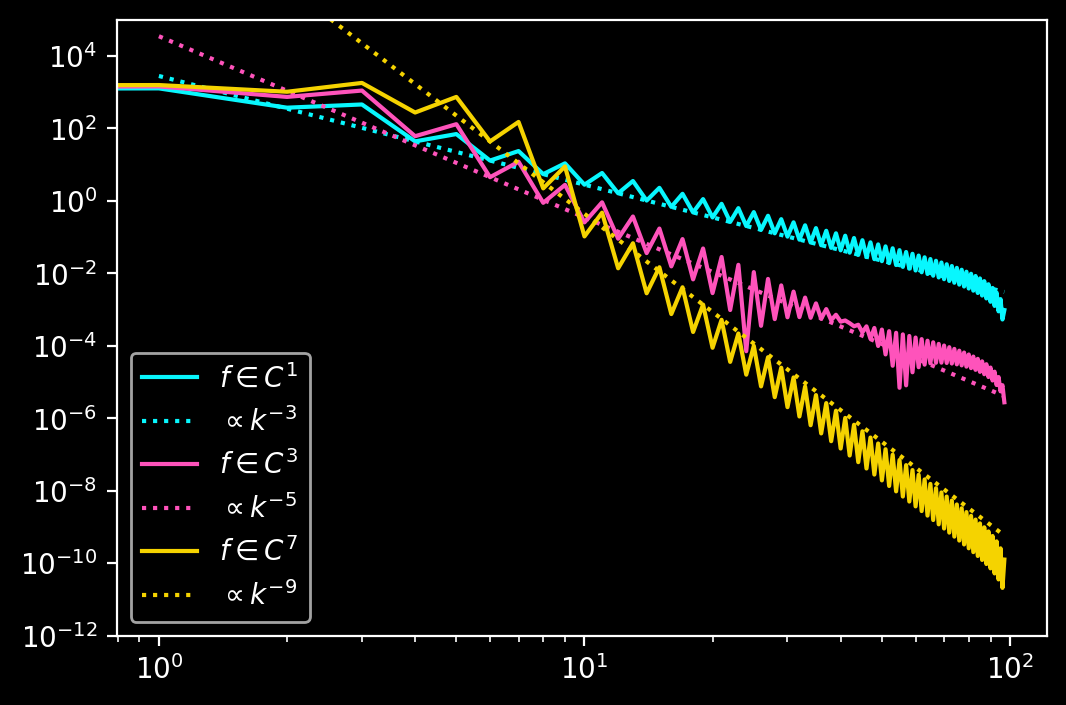

In [43]:
# Configurable parameters
N     = 100 # Size of input domain

# Define the domain and the function
L = np.pi
x = np.linspace(0, L, N)
def func(x):
    return np.exp(x)
f = func(x)
dx = x[1] - x[0]

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
#plt.axis("off")
for i, n_accuracy in enumerate([0, 1, 3]):
    # Get the shift function and coefficients
    shift, C = get_shift_function(f, n_accuracy, x)
    print(len(C))

    hom      = f - shift
    f_ext    = antisymmetric_extension(hom)
    f_hat    = scipy.fft.fft(f_ext)

    # Get the k values
    k = get_k(f_hat, dx)
    n = int(len(f_hat)/2) - 1
    n_start = 6
    n_poly = -2 * n_accuracy - 3
    plt.loglog(k[:n], np.abs(f_hat[:n]), c=colors[i], label = "$f\in C^{" + f"{2*n_accuracy + 1}" + r"}$")
    plt.loglog(k[0:n], np.abs(f_hat[n_start]) * (k[0:n]**n_poly)/(k[n_start]**n_poly), c=colors[i], ls="dotted", label=r"$\propto k^{"+f"{n_poly}"+r"}$")

plt.legend()
plt.ylim(1e-12, 1e5)
plt.savefig("figures/subtraction_trigonometric_decay.png", bbox_inches='tight')
plt.show()

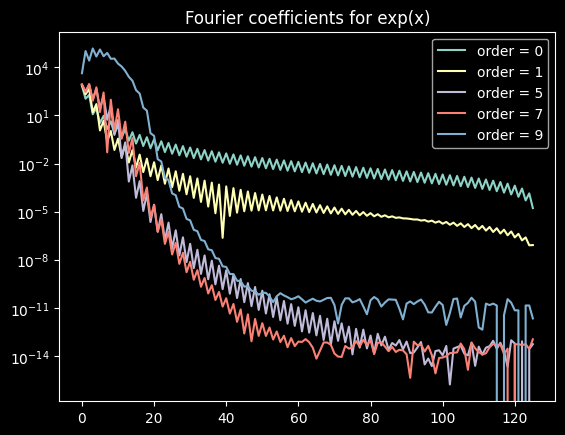

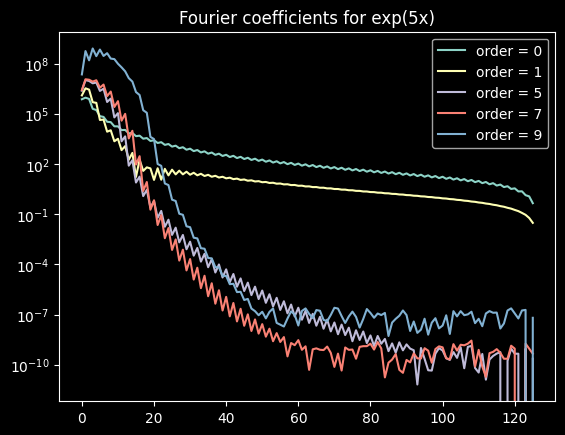

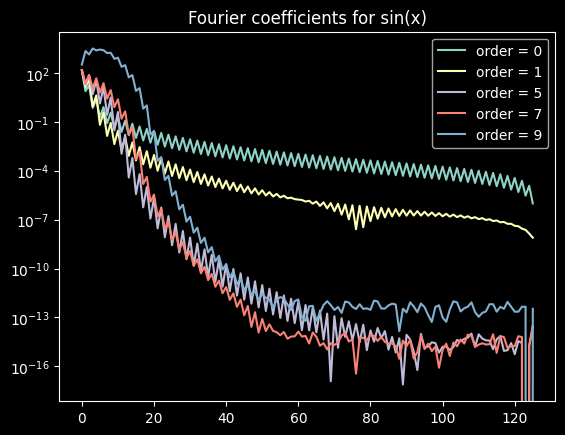

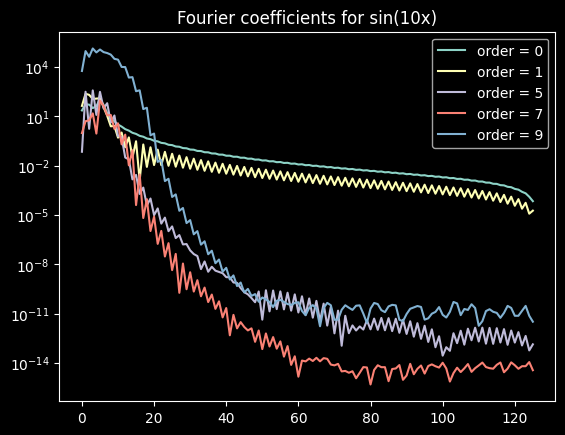

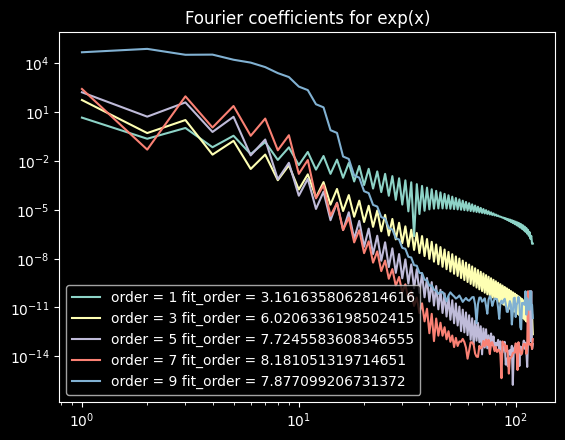

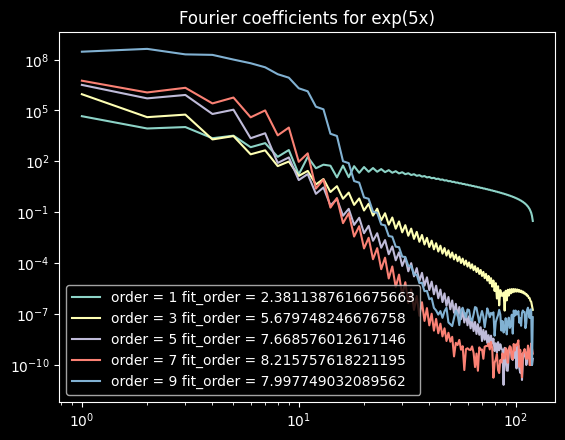

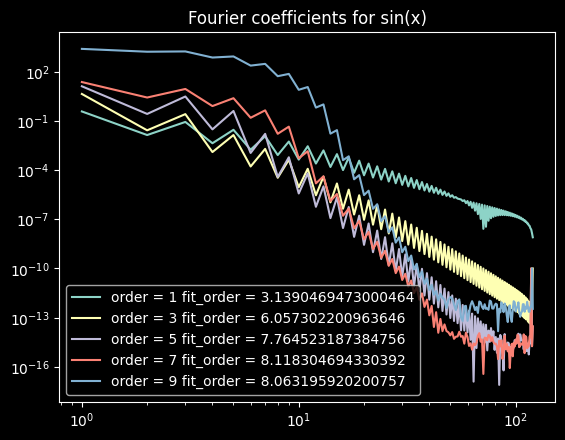

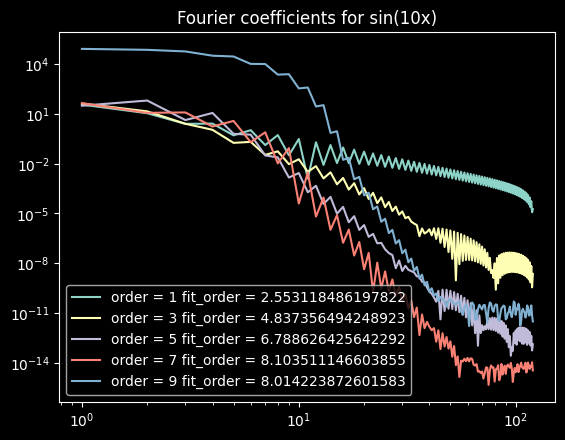

In [44]:
x = np.linspace(0, 2, 128)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns):
    plt.title(f"Fourier coefficients for {n}")
    plt.yscale("log")
    for order in [0, 1, 5, 7, 9]:
        shift, C = get_shift_function(f, order, x)
        hom = f - shift
        fhat = scipy.fft.dst(hom[1:-1], type=1)
        plt.plot(np.abs(fhat), label=f"order = {order}")
    plt.legend()
    plt.show()


for f, n in zip(fs, ns):
    plt.title(f"Fourier coefficients for {n}")
    for order in [1, 3, 5, 7, 9]:
        shift, C = get_shift_function(f, order, x)
        hom = f - shift
        fhat = scipy.fft.dst(hom[1:-1], type=1)
        y    = np.abs(fhat)
        y[y==0] = 1e-10
        y    = y[6:]
        r    = np.arange(1, len(y)+1)
        def fitfunc(x, beta):
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y))
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}")
    plt.legend()
    plt.show()

## Polynomial subtraction

For the polynomial subtraction, I demonstrate a slightly different approach. 
I do not construct an antisymmetric extension, but simply subtract all derivatives so that the remainder becomes periodic. 
In principle, I would have expected antisymmetric extensions to yield higher accuracy because one achieves more continuous derivatives with the same polynomial order. But my numerical experiments indicate that this is not necessarily the case. 

- Given a grid: $0, \Delta x, ..., L - \Delta x, L$
- Estimate derivatives $f^{(0)}(x_0), f^{(0)}(x_1), f^{(1)}(x_0), f^{(1)}(x_1), $... of $f(x)$ at $x_0=0$ and $x_1 = L$ 
- Set them to $0$ by subtracting suitable linear combinations of polynomials evaluated on the discrete grid
- Accurate Fourier transform of periodic function

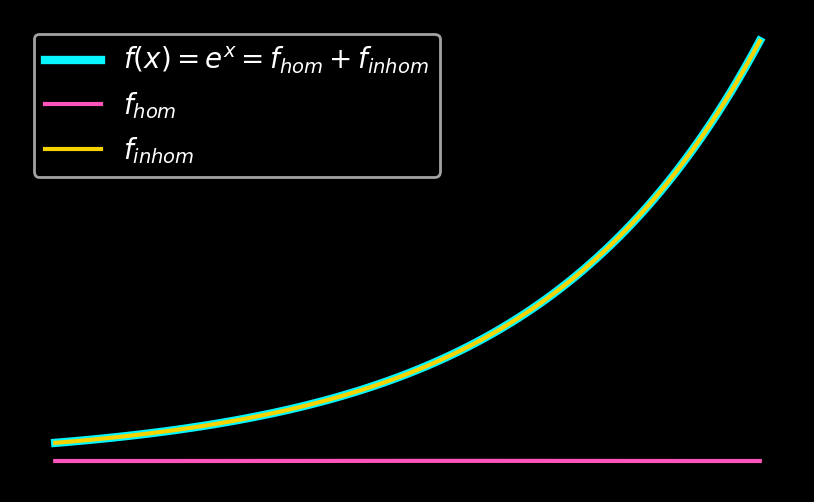

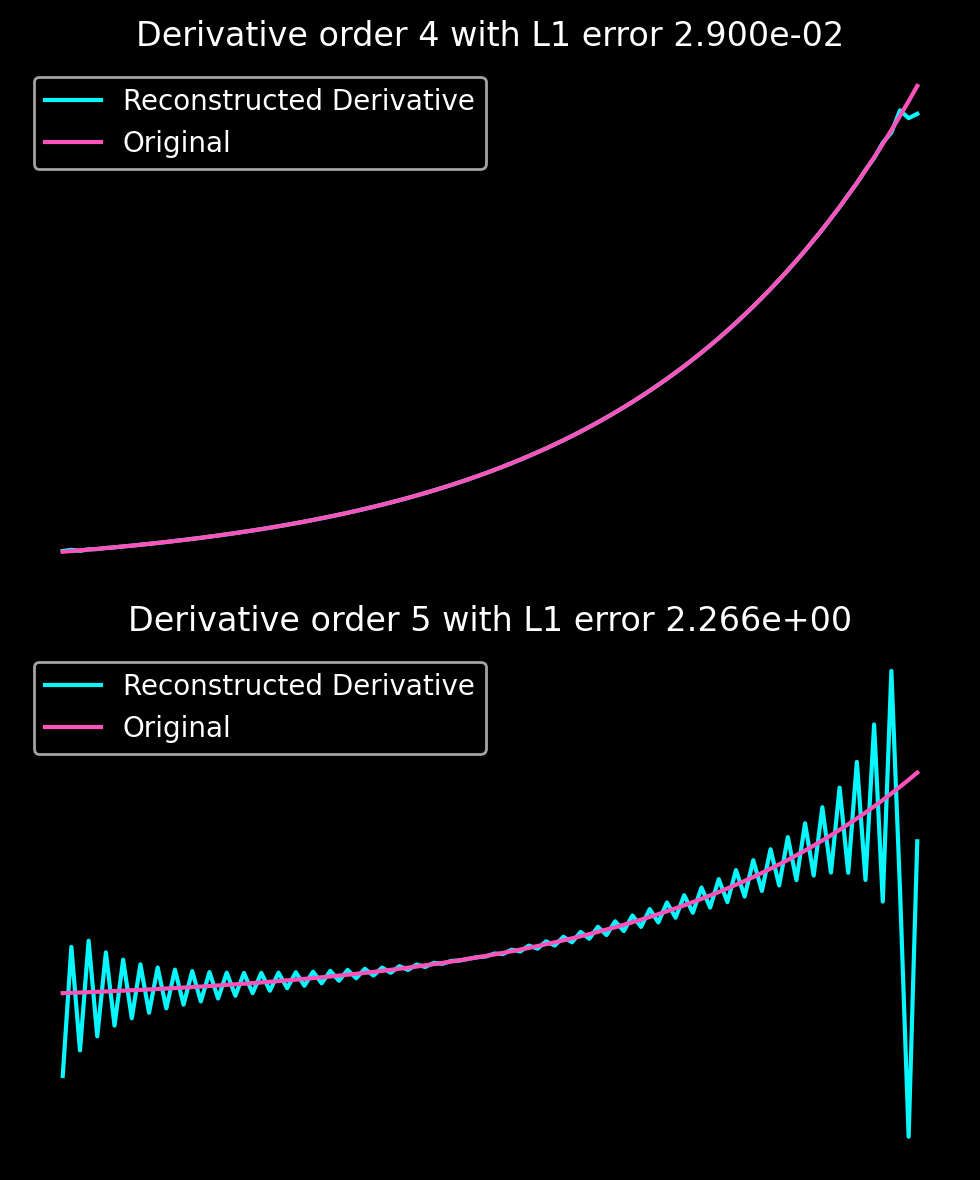

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import scipy.interpolate

# Constants for finite difference modes
MODE_FORWARD = 0
MODE_CENTERED = 1
MODE_BACKWARD = 2
MODE_CUSTOM = 3

# Max derivative order allowed
MAX_DERIVATIVE_ORDER = 30

# Finite difference stencils for forward, backward, and centered modes
fstencils = []
bstencils = []
cstencils = []


def compute_fd_coefficients(derivative_order, n_accuracy, mode, stencil=None):
    """
    Compute finite difference coefficients for given derivative order and n_accuracy.

    Args:
        derivative_order (int): The order of the derivative.
        n_accuracy (int): The n_accuracy of the approximation.
        mode (int): The mode of finite difference (forward, backward, centered, custom).
        stencil (np.array): The points used for the finite difference.

    Returns:
        tuple: A tuple containing the stencil and the coefficients.
    """
    stencil_length = derivative_order + n_accuracy

    if mode == MODE_FORWARD:
        stencil = np.arange(0, stencil_length)
    elif mode == MODE_BACKWARD:
        stencil = np.arange(-stencil_length + 1, 1)
    elif mode == MODE_CENTERED:
        if n_accuracy % 2 != 0:
            raise ValueError("Centered stencils available only with even n_accuracy orders")
        if (stencil_length % 2 == 0) and stencil_length >= 4:
            stencil_length -= 1
        half_stencil_length = int((stencil_length - 1) / 2)
        stencil = np.arange(-half_stencil_length, half_stencil_length + 1)
    elif mode == MODE_CUSTOM:
        if stencil is None:
            raise ValueError("Custom stencil needed in MODE_CUSTOM")
        stencil_length = len(stencil)
        if derivative_order >= stencil_length:
            raise ValueError("Derivative order must be smaller than stencil length")

    A = np.zeros((stencil_length, stencil_length))
    b = np.zeros(stencil_length)

    for i in range(stencil_length):
        A[i, :] = stencil ** i
    b[derivative_order] = np.math.factorial(derivative_order)

    coefficients = np.linalg.solve(A, b)
    return stencil, coefficients


# Populate the finite difference stencils for forward, backward, and centered modes
for i in range(MAX_DERIVATIVE_ORDER):
    N_MAX = i + 2
    fstencils_at_order_i = []
    bstencils_at_order_i = []
    cstencils_at_order_i = []
    for order in range(1, N_MAX):
        c = compute_fd_coefficients(order, N_MAX - order + ((N_MAX - order) % 2 != 0), MODE_CENTERED)
        f = compute_fd_coefficients(order, N_MAX - order, MODE_FORWARD)
        b = compute_fd_coefficients(order, N_MAX - order, MODE_BACKWARD)
        fstencils_at_order_i.append(f)
        bstencils_at_order_i.append(b)
        cstencils_at_order_i.append(c)
    fstencils.append(fstencils_at_order_i)
    bstencils.append(bstencils_at_order_i)
    cstencils.append(cstencils_at_order_i)


def compute_derivative(f, j, dx, stencil, derivative_order=1):
    """
    Compute the derivative of a function at a point.

    Args:
        f (np.array): The function values.
        j (int): The index of the point.
        dx (float): The spacing between points.
        stencil (tuple): The stencil and coefficients for finite differences.
        derivative_order (int): The order of the derivative.

    Returns:
        float: The derivative of the function at point j.
    """
    shifts, coeff = stencil
    f_dx = sum(f[j + shift] * coeff[i] for i, shift in enumerate(shifts))
    return f_dx / dx ** derivative_order


def get_polynomial_shift_function(f, n_accuracy, x):
    """
    Compute the polynomial shift function to fulfill Dirichlet boundary conditions.

    Args:
        f (np.array): The function values.
        n_accuracy(int): The number of derivatives made continuous: f - shift will be in the set of continuous, order-times differentiable functions C^order(x)
        x (np.array): The domain of the function.

    Returns:
        tuple: The polynomial shift function and the interpolating polynomial.
    """
    dx = x[1] - x[0]
    x0, x1 = x[0], x[-1]
    f0, f1 = f[0], f[-1]

    N_columns    = 1 + n_accuracy
    fd_f_stencil = fstencils[n_accuracy - 1]
    fd_b_stencil = bstencils[n_accuracy - 1]

    B = np.zeros((N_columns, len(f)), f.dtype)

    bc_l = [(i + 1, compute_derivative(f, 0, dx, fd_f_stencil[i], i + 1)) for i in range(n_accuracy)]
    bc_r = [(i + 1, compute_derivative(f, -1, dx, fd_b_stencil[i], i + 1)) for i in range(n_accuracy)]

    bc = (bc_l, bc_r)

    poly = scipy.interpolate.make_interp_spline([x0, x1], [f0, f1], k=2 * n_accuracy + 1, bc_type=bc, axis=0)

    for i in range(n_accuracy + 1):
        B[i] = poly(x, i * 2)

    return B[:, :len(x)], poly


# Configurable parameters
N        = 100  # Size of input domain
# Accuracy of the subtraction, this leads to a polynomial of order 2*n_accuracy + 1 being subtracted from the original function
n_accuracy = 4

# Define the domain and the function
L = np.pi
x = np.linspace(0, L, N)


def func(x):
    """Function to compute e^x."""
    return np.exp(x)


f = func(x)
dx = x[1] - x[0]

# Create shift function such that f - B fulfills Dirichlet boundary conditions
shift, polynomial_func = get_polynomial_shift_function(f = f, n_accuracy=n_accuracy, x = x)
f_ext = f - shift[0]
f_hat = scipy.fft.fft(f_ext)

# Function to get k values
k = get_k(f_hat, dx)

colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]

plt.style.use('dark_background')
plt.figure(figsize=(5, 3), dpi=200)
plt.axis("off")
plt.plot(f, c=colors[0], lw=3, label=r"$f(x) = e^x = f_{hom} + f_{inhom}$")
plt.plot(f_ext, c=colors[1], label=r"$f_{hom}$")
plt.plot(shift[0], c=colors[2], label=r"$f_{inhom}$")
plt.legend()
plt.savefig("figures/subtraction_polynomial_extension.png", bbox_inches='tight')
plt.show()

# Number of subplots
num_subplots = 2

# Create subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(5, 3* num_subplots), dpi=200)

# Loop through different subtraction orders
for i, o in enumerate([4, 5]):
    forg = func(x)
    frec = scipy.fft.ifft(f_hat * (1j * k) ** o).real  # Use only the first N elements (the original domain)
    reco = polynomial_func(x, o)
    sumo = frec + reco

    # Plot the sum and the original function in subplots
    axs[i].set_title(f"Derivative order {o} with L1 error {np.mean(np.abs(sumo - forg)):3.3e}")
    axs[i].plot(x, sumo, label="Reconstructed Derivative", c=colors[0])
    axs[i].plot(x, forg, label="Original", c=colors[1])
    axs[i].legend()



    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].get_xaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

# Adjust layout
plt.tight_layout()
plt.savefig("figures/subtraction_polynomial_accuracy.png")
plt.show()


Note that the 5th derivative suffers from order unity errors since we only ensure that the homogeneous function is periodic up to fourth order. For a mathematical analysis, see the Sköllermo paper. 

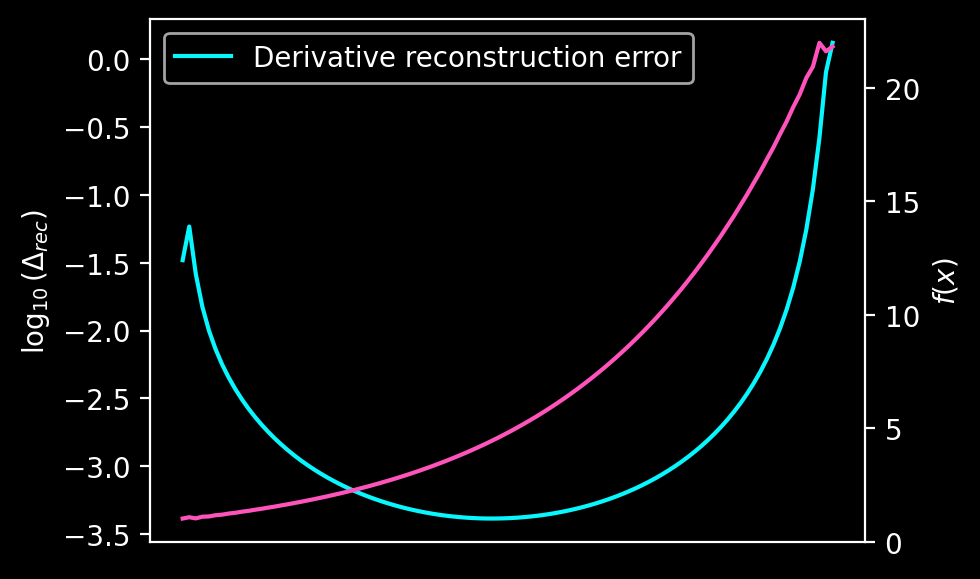

In [46]:
num_subplots = 1

# Create subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(5, 3* num_subplots), dpi=200)

# Loop through different subtraction orders
o = 4
forg = func(x)
frec = scipy.fft.ifft(f_hat * (1j * k) ** o).real  # Use only the first N elements (the original domain)
reco = polynomial_func(x, o)
sumo = frec + reco

# Plot the sum and the original function in subplots
ax2 = axs.twinx()
ax2.plot(x, sumo, label="Reconstructed Derivative", c=colors[1])

axs.plot(x, np.log10(np.abs(forg - sumo)), label="Derivative reconstruction error", c=colors[0])
axs.legend()


axs.set_ylabel(r"$\log_{10}(\Delta_{rec})$")
ax2.set_ylabel(r"$f(x)$")
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.get_xaxis().set_ticks([])
#axs.get_yaxis().set_ticks([])

# Adjust layout
plt.tight_layout()
plt.savefig("figures/subtraction_polynomial_log_accuracy.png", bbox_inches='tight')
plt.show()


### Decay of Fourier coefficients as function of subtraction order

/tmp/ipykernel_6637/2234955572.py:26: RuntimeWarning: divide by zero encountered in power
  plt.loglog(k[0:n], np.abs(f_hat[n_start]) * (k[0:n]**(-n_accuracy - 1))/(k[n_start]**(-n_accuracy - 1)), c=colors[i], ls="dotted", label=r"$\propto k^{"+f"{-n_accuracy-1}"+r"}$")


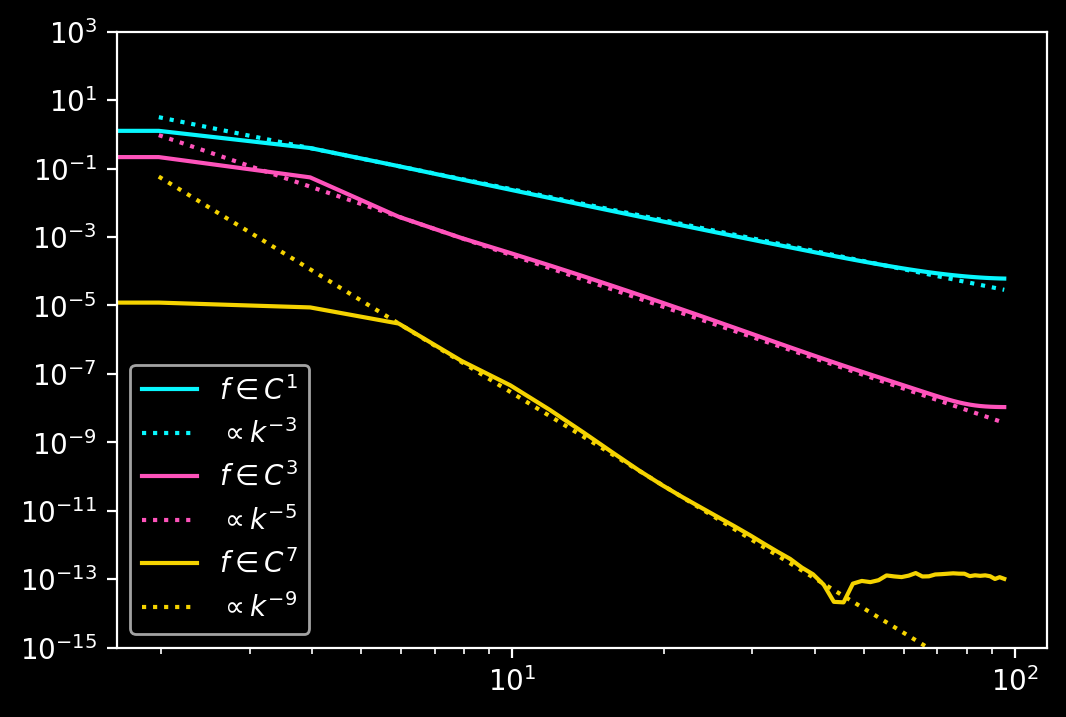

In [47]:

# Configurable parameters
N     = 100  # Size of input domain

# Define the domain and the function
L = np.pi
x = np.linspace(0, L, N)

def func(x):
    return np.exp(x)

f = func(x)

plt.figure(figsize=(6, 4), dpi=200)

for i, n_accuracy in enumerate([2, 4, 8]):
    # Get the shift function and coefficients
    shift, polynomial_func = get_polynomial_shift_function(f, n_accuracy, x)
    hom      = f - shift[0]
    f_hat    = scipy.fft.fft(hom)

    # Get the k values
    k = get_k(f_hat, dx)
    n = int(len(f_hat)/2) - 1
    n_start = 3
    plt.loglog(k[:n], np.abs(f_hat[:n]), c=colors[i], label = r"$f\in C^{" + f"{n_accuracy - 1}" + r"}$")
    plt.loglog(k[0:n], np.abs(f_hat[n_start]) * (k[0:n]**(-n_accuracy - 1))/(k[n_start]**(-n_accuracy - 1)), c=colors[i], ls="dotted", label=r"$\propto k^{"+f"{-n_accuracy-1}"+r"}$")

plt.legend()
plt.ylim(1e-15, 1e3)
plt.savefig("figures/subtraction_polynomial_decay.png")
plt.show()